In [23]:
import pandas as pd

df = pd.read_csv("churn-bigml-80.csv")
df.head()


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [24]:
missing_cnt = df.isnull().sum()
df.isnull().values.any()

np.False_

In [25]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

outlier_info = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_info[col] = len(outliers)

pd.Series(outlier_info).sort_values(ascending=False)

Customer service calls    210
Total intl calls           66
Total intl charge          40
Total intl minutes         37
Total night minutes        22
Total night charge         22
Total day minutes          21
Total day charge           21
Total night calls          19
Total day calls            18
Total eve minutes          17
Total eve charge           17
Total eve calls            15
Account length             12
Number vmail messages       2
Area code                   0
dtype: int64

In [26]:
(df[num_cols] < 0).sum().sort_values(ascending=False)

Account length            0
Area code                 0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
dtype: int64

In [27]:
df["Customer service calls"].describe()

count    2666.000000
mean        1.562641
std         1.311236
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: Customer service calls, dtype: float64

In [28]:
#Customer service calls 클리핑
df_clip = df.copy()
col = "Customer service calls"
lower = df_clip[col].quantile(0.01)
upper = df_clip[col].quantile(0.99)
df_clip[col] = df_clip[col].clip(lower, upper)
lower, upper

(np.float64(0.0), np.float64(6.0))

In [29]:
#범주형 변수 식별
df.dtypes
df.select_dtypes(include=["object"]).columns

Index(['State', 'International plan', 'Voice mail plan'], dtype='object')

In [30]:
#수치형 변수 스케일 요약표 각 컬럼의 min max std 확인
scale_summary = df[num_cols].describe().T
scale_summary[["min", "max", "mean", "std"]].sort_values("max", ascending=False)

,min,max,mean,std
Area code,408.00,510.00,437.438860,42.521018
Total night minutes,43.70,395.00,201.168942,50.780323
Total eve minutes,0.00,363.70,200.386159,50.951515
Total day minutes,0.00,350.80,179.481620,54.210350
Account length,1.00,243.00,100.620405,39.563974
Total eve calls,0.00,170.00,100.023631,20.161445
Total night calls,33.00,166.00,100.106152,19.418459
Total day calls,0.00,160.00,100.310203,19.988162
Total day charge,0.00,59.64,30.512404,9.215733
Number vmail messages,0.00,50.00,8.021755,13.612277


In [31]:
#수치형 변수 스케일 range 확인
scale_summary["range"] = scale_summary["max"] - scale_summary["min"]
scale_summary[["min", "max", "range"]].sort_values("range", ascending=False)

,min,max,range
Total eve minutes,0.00,363.70,363.70
Total night minutes,43.70,395.00,351.30
Total day minutes,0.00,350.80,350.80
Account length,1.00,243.00,242.00
Total eve calls,0.00,170.00,170.00
Total day calls,0.00,160.00,160.00
Total night calls,33.00,166.00,133.00
Area code,408.00,510.00,102.00
Total day charge,0.00,59.64,59.64
Number vmail messages,0.00,50.00,50.00


In [32]:
df["International plan"].value_counts()
df2 = df.copy()

df2["International plan"] = (
    df2["International plan"]
    .astype(str).str.lower().str.strip()
    .map({"yes": 1, "no": 0})
)

df2[["International plan"]].head()

df2["Churn"] = df2["Churn"].astype(int)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 분석할 변수 지정
key_vars = ["Customer service calls", "International plan", "Total day charge"]
target = "Churn"

# 타겟(Churn) 불균형 비율 계산
churn_counts = df[target].value_counts(dropna=False)
churn_ratio = df[target].value_counts(normalize=True, dropna=False) * 100
print("=== Churn 분포(개수) ===")
print(churn_counts)
print("\n=== Churn 분포(비율 %) ===")
print(churn_ratio.round(2))



=== Churn 분포(개수) ===
Churn
False    2278
True      388
Name: count, dtype: int64

=== Churn 분포(비율 %) ===
Churn
False    85.45
True     14.55
Name: proportion, dtype: float64


In [34]:
# 분석 변수들을 수치형/범주형으로 분리
num_vars = [c for c in key_vars if pd.api.types.is_numeric_dtype(df[c])]
cat_vars = [c for c in key_vars if not pd.api.types.is_numeric_dtype(df[c])]

# 수치형 변수: 기술통계량(평균, 중앙값, 표준편차, 사분위수) 출력
if len(num_vars) > 0:
    stats = df[num_vars].agg(["mean", "median", "std", "min",
                              lambda s: s.quantile(0.25),
                              lambda s: s.quantile(0.50),
                              lambda s: s.quantile(0.75),
                              "max"]).T
    stats.columns = ["mean", "median", "std", "min", "q1(25%)", "q2(50%)", "q3(75%)", "max"]
    print("\n=== 수치형 기술통계량 ===")
    print(stats.round(4))



=== 수치형 기술통계량 ===
                           mean  median     std  min  q1(25%)  q2(50%)  \
Customer service calls   1.5626    1.00  1.3112  0.0     1.00     1.00   
Total day charge        30.5124   30.59  9.2157  0.0    24.38    30.59   

                        q3(75%)    max  
Customer service calls      2.0   9.00  
Total day charge           36.7  59.64  


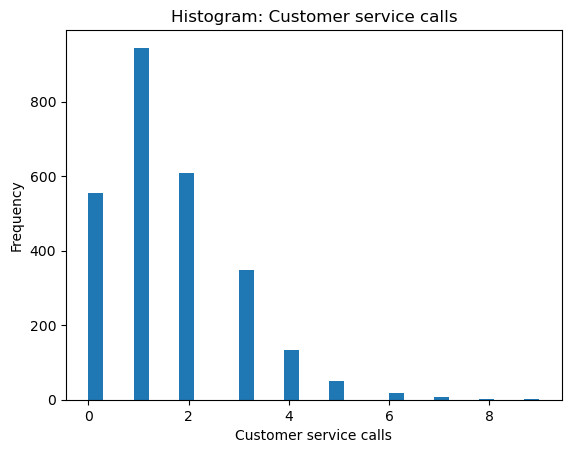

<Figure size 640x480 with 0 Axes>

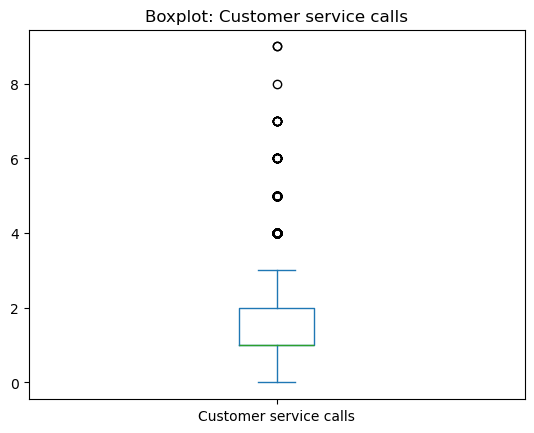

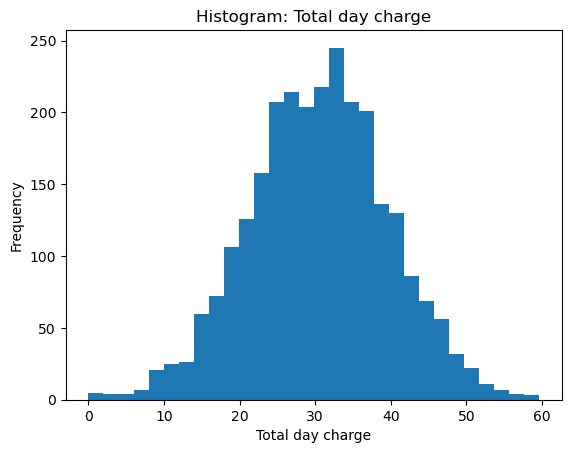

<Figure size 640x480 with 0 Axes>

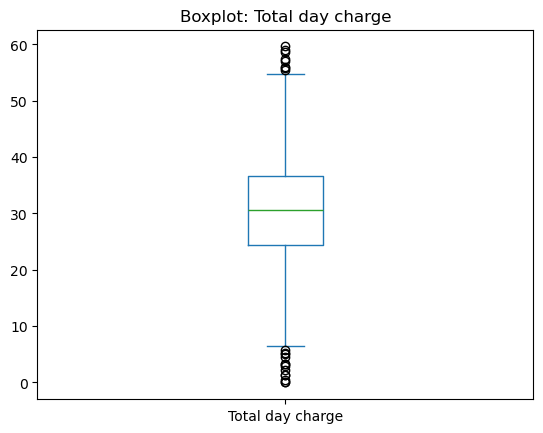

In [35]:
# 수치형 변수: 히스토그램 & 박스플롯
for col in num_vars:
    # 히스토그램
    plt.figure()
    df[col].plot(kind="hist", bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

    # 박스플롯
    plt.figure()
    df[[col]].plot(kind="box")
    plt.title(f"Boxplot: {col}")
    plt.show()



=== 빈도표: International plan ===
International plan
No     2396
Yes     270
Name: count, dtype: int64


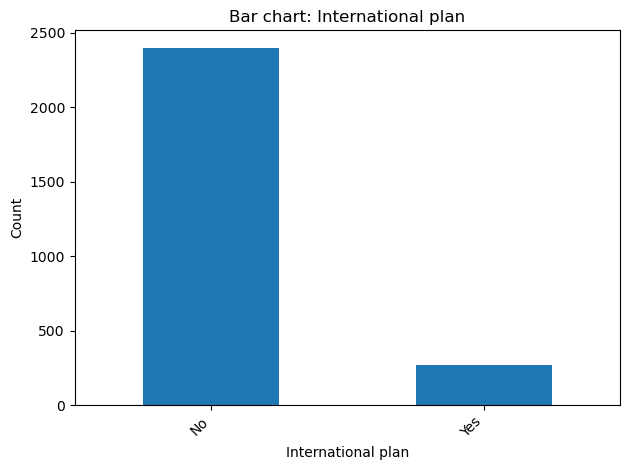

In [36]:
# 범주형 변수: 빈도표 & 막대그래프
for col in cat_vars:
    freq = df[col].value_counts(dropna=False)
    print(f"\n=== 빈도표: {col} ===")
    print(freq)

    plt.figure()
    freq.plot(kind="bar")
    plt.title(f"Bar chart: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [37]:
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

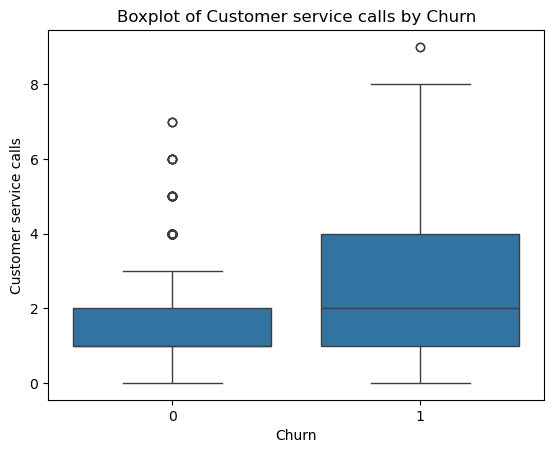

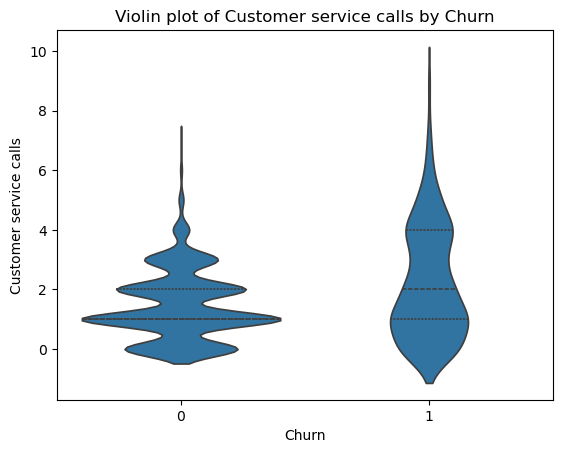


=== t-test: Customer service calls ===
t-statistic = -7.6406, p-value = 0.000000


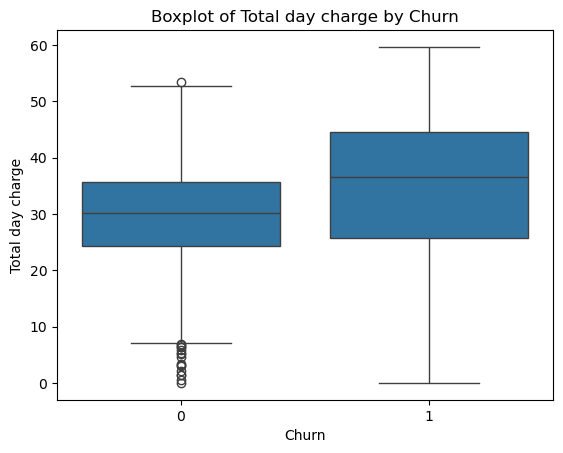

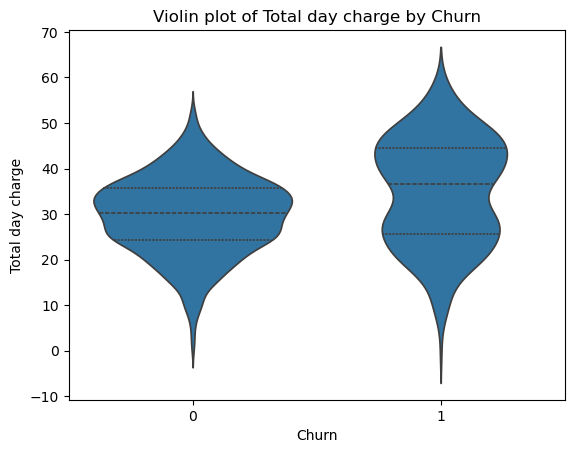


=== t-test: Total day charge ===
t-statistic = -8.2808, p-value = 0.000000


In [38]:

# 1) 분석 변수 지정
num_vars = ["Customer service calls", "Total day charge"]
cat_vars = ["International plan"]
target = "Churn"

# 2) 원본 보호 + 컬럼명 정리
df2 = df.copy()
df2.columns = df2.columns.str.strip()

# 3) Churn을 0/1로 변환
df2[target] = df2[target].astype(int)

# -----------------------------
# A) 수치형 변수 vs Churn
# -----------------------------
for col in num_vars:
    # 4) 박스플롯(Churn 그룹별)
    plt.figure()
    sns.boxplot(data=df2, x=target, y=col)
    plt.title(f"Boxplot of {col} by Churn")
    plt.show()

    # 5) 바이올린 플롯(Churn 그룹별 분포 모양까지)
    plt.figure()
    sns.violinplot(data=df2, x=target, y=col, inner="quartile")
    plt.title(f"Violin plot of {col} by Churn")
    plt.show()

    # 6) t-test (연속형 변수 평균 차이 유의성)
    group0 = df2[df2[target] == 0][col]
    group1 = df2[df2[target] == 1][col]
    t_stat, p_value = ttest_ind(group0, group1, equal_var=False)

    print(f"\n=== t-test: {col} ===")
    print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")




=== Crosstab: International plan vs Churn ===
Churn                  0    1
International plan           
No                  2126  270
Yes                  152  118

=== Churn Rate(%) by International plan ===
International plan
No     11.27
Yes    43.70
dtype: float64


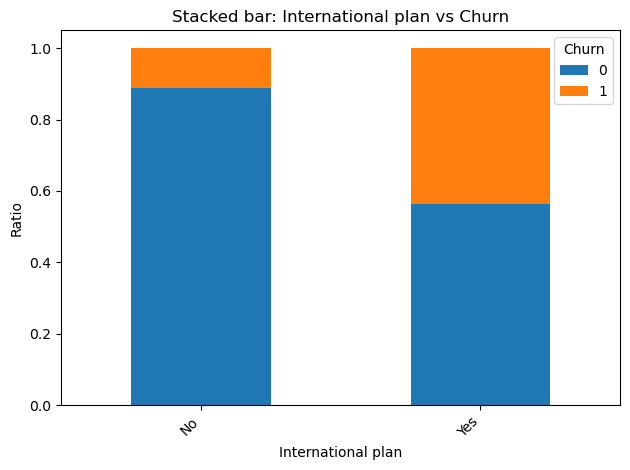


=== Chi-square test: International plan ===
chi2 = 202.6821, p-value = 0.000000


In [39]:
# -----------------------------
# B) 범주형 변수 vs Churn
# -----------------------------
for col in cat_vars:
    # 7) 교차표 (범주형 x Churn)
    ct = pd.crosstab(df2[col], df2[target])
    print(f"\n=== Crosstab: {col} vs Churn ===")
    print(ct)

    # 8) 이탈률(Churn=1 비율) 계산
    churn_rate = (ct[1] / ct.sum(axis=1) * 100).round(2)
    print(f"\n=== Churn Rate(%) by {col} ===")
    print(churn_rate)

    # 9) 스택 바 차트(비율)
    ct_norm = ct.div(ct.sum(axis=1), axis=0)
    ct_norm.plot(kind="bar", stacked=True)
    plt.title(f"Stacked bar: {col} vs Churn")
    plt.ylabel("Ratio")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 10) Chi-square test (범주형 변수 유의성)
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"\n=== Chi-square test: {col} ===")
    print(f"chi2 = {chi2:.4f}, p-value = {p:.6f}")


In [40]:
# -----------------------------
# C) 핵심 인사이트 예시: 고객센터 4회 이상 이탈률
# -----------------------------
df2["cs_4plus"] = (df2["Customer service calls"] >= 4).astype(int)

insight_ct = pd.crosstab(df2["cs_4plus"], df2[target])
rate_4plus = (insight_ct.loc[1, 1] / insight_ct.loc[1].sum() * 100).round(2)
rate_under4 = (insight_ct.loc[0, 1] / insight_ct.loc[0].sum() * 100).round(2)

print("\n=== Insight: Customer service calls >= 4 ===")
print(f"Churn rate (>=4 calls)  : {rate_4plus}%")
print(f"Churn rate (<4 calls)   : {rate_under4}%")


=== Insight: Customer service calls >= 4 ===
Churn rate (>=4 calls)  : 52.86%
Churn rate (<4 calls)   : 11.28%


In [44]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor


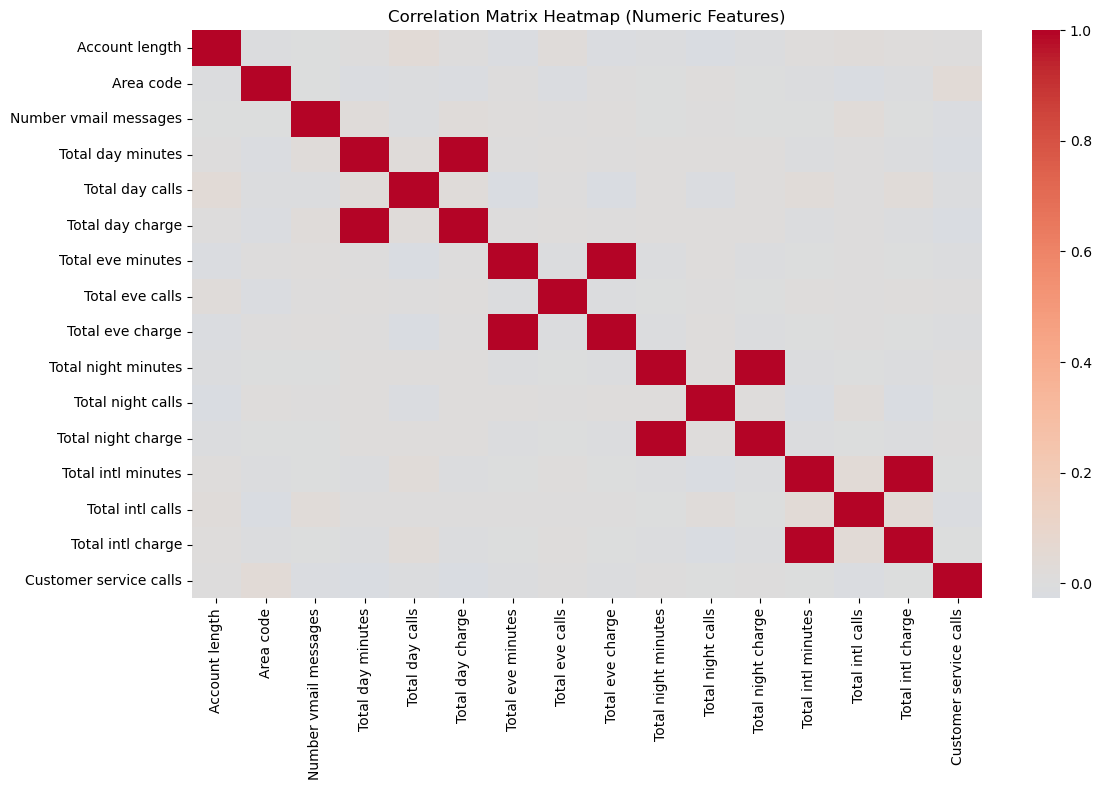

In [42]:

df2 = df.copy()
df2.columns = df2.columns.str.strip()
num_cols = df2.select_dtypes(include=["int64", "float64"]).columns.tolist()
corr = df2[num_cols].corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()



In [45]:
# 다중공선성(VIF) 확인
X_vif = df2[num_cols].dropna().copy() 
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna() 

vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.sort_values("VIF", ascending=False)
print("\n=== VIF (다중공선성 지표) ===")
print(vif_df)




=== VIF (다중공선성 지표) ===
                   feature           VIF
5         Total day charge  1.245859e+08
3        Total day minutes  1.245811e+08
8         Total eve charge  3.779054e+07
6        Total eve minutes  3.778888e+07
9      Total night minutes  1.081542e+07
11      Total night charge  1.081538e+07
14       Total intl charge  9.899192e+05
12      Total intl minutes  9.895024e+05
1                Area code  6.046071e+01
10       Total night calls  2.483799e+01
4          Total day calls  2.377252e+01
7          Total eve calls  2.314027e+01
0           Account length  7.315518e+00
13        Total intl calls  4.276114e+00
15  Customer service calls  2.418684e+00
2    Number vmail messages  1.349469e+00


In [46]:
drop_cols = [
    "Total day minutes", "Total eve minutes",
    "Total night minutes", "Total intl minutes"
]
df3 = df2.drop(columns=drop_cols)

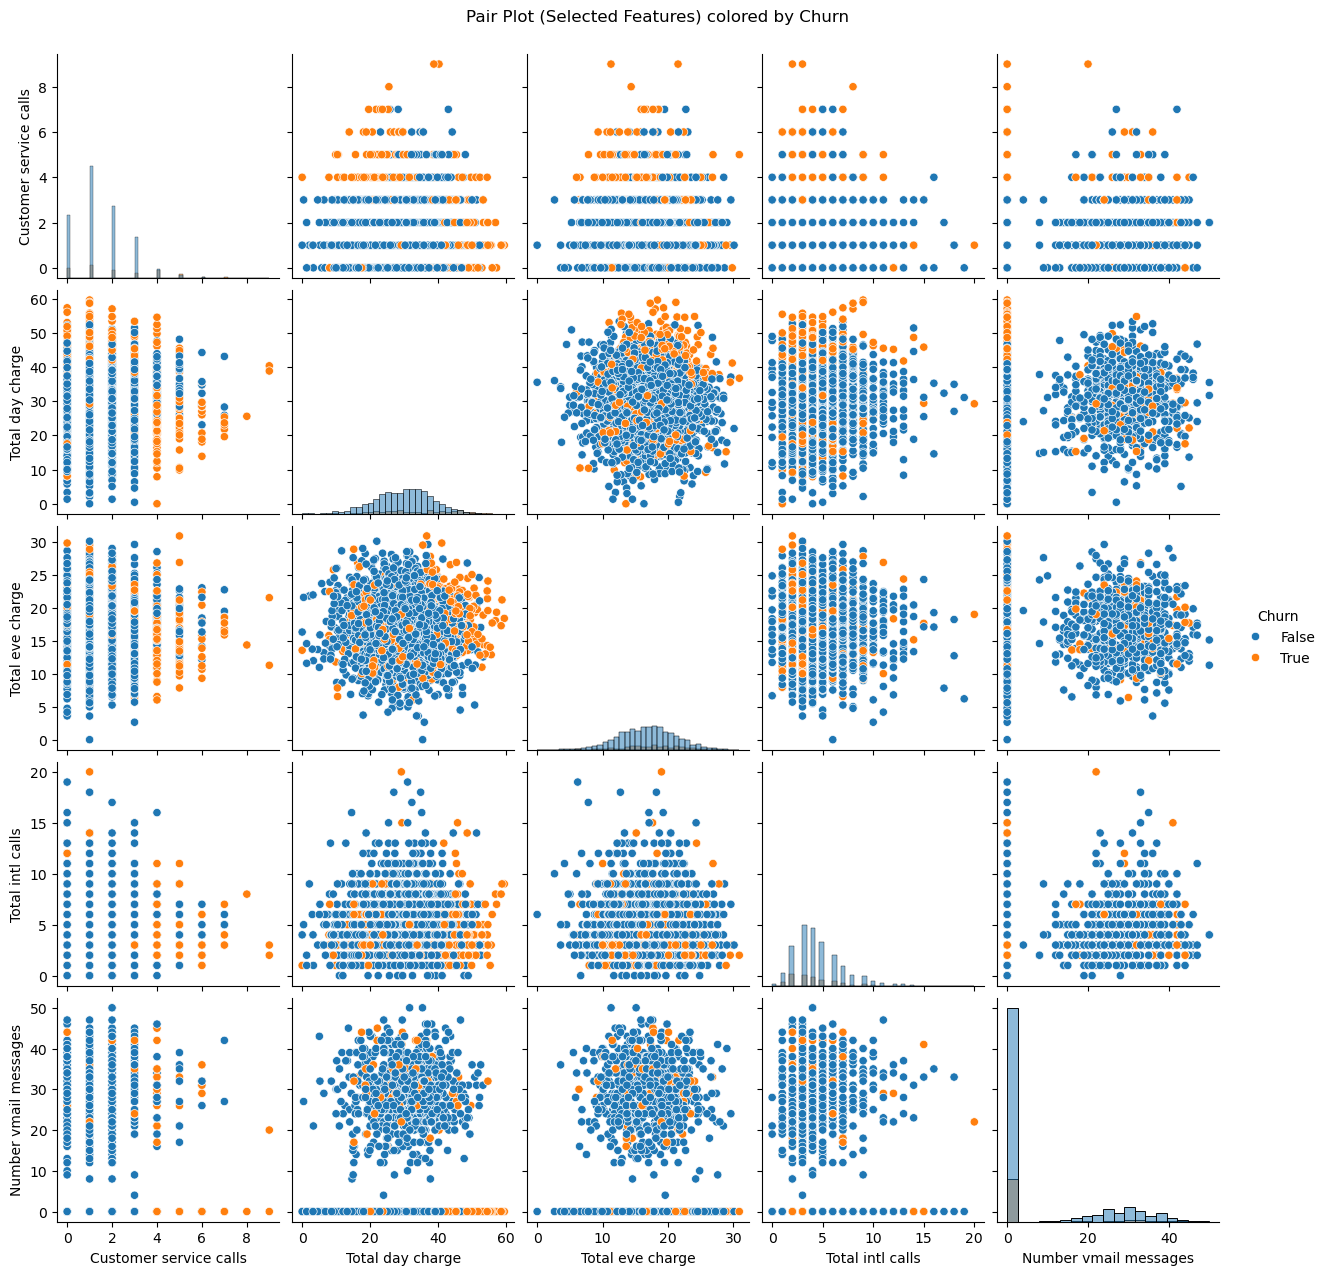

In [47]:
# Pair plot 
pair_cols = ["Customer service calls", "International plan", "Total day charge", "Total eve charge", "Total intl calls", "Number vmail messages" 
, "Churn"]


sns.pairplot(df2[pair_cols].dropna(), hue="Churn", diag_kind="hist")
plt.suptitle("Pair Plot (Selected Features) colored by Churn", y=1.02)
plt.show()



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# 1) 파일 로드 
train_df = pd.read_csv("churn-bigml-80.csv")
test_df  = pd.read_csv("churn-bigml-20.csv")

# 2) 컬럼명 공백 제거
train_df.columns = train_df.columns.str.strip()
test_df.columns  = test_df.columns.str.strip()

# 3) 타겟/피처 지정 
target = "Churn"
features = ["Customer service calls", "International plan", "Total day charge"]

# 4) X, y 분리
X_train = train_df[features]
y_train = train_df[target].astype(int)

X_test  = test_df[features]
y_test  = test_df[target].astype(int)

# 5) 수치/범주 컬럼 구분
num_cols = ["Customer service calls", "Total day charge"]
cat_cols = ["International plan"]

# 6) 전처리 

categorical_tf = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

# 7) Random Forest 모델
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

# 8) 전처리 + 모델을 한 번에 묶기
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

# 9) 학습
clf.fit(X_train, y_train)

# 10) 예측/평가
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, pred)
f1  = f1_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC : {auc:.4f}\n")

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, pred))

Accuracy: 0.8516
F1-score: 0.4923
ROC-AUC : 0.8208

=== Confusion Matrix ===
[[520  52]
 [ 47  48]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       572
           1       0.48      0.51      0.49        95

    accuracy                           0.85       667
   macro avg       0.70      0.71      0.70       667
weighted avg       0.85      0.85      0.85       667

